In [ ]:
!pip install cirq

In [ ]:
import numpy as np
import random
import time
import itertools as itert
import cirq
import matplotlib.pyplot as plt
import math


GROVER'S

Implementation using custom matrices. This is just for practice and the final implementation using CZ and X gates are below.

In [ ]:
def getFx(n, verbose, num_ans = 0):
    if num_ans == 0:
        num_ans = np.random.randint(low = 1, high = 2**n)

    if verbose:
        print('Number of x such that f(x) = 1: ', num_ans)

    randList = random.sample(range(0, 2**n), num_ans)
    for i in range(num_ans):
        x = randList[i]
        maxLength = len(bin(2**n-1)[2:])
        binary = (bin(x))[2:]  
        currLength = len(binary)
        ansBinary = '0' * (maxLength - currLength)
        ansBinary += binary

        if verbose:
            print(i + 1, 'th one is: ', ansBinary)

    return randList

def createZ0(n, verbose):
    z0Matrix = np.eye(2**(n))
    z0Matrix[0][0] = -1

    if verbose:
        print("Matrix Z0:")
        print(z0Matrix)
    
    return z0Matrix

def createZf(n, fnlist, verbose):
    ufMatrix = np.eye(2**n)

    for x in fnlist:
        ufMatrix[x][x] = -1

    if verbose:
        print("Matrix Zf:")
        print(ufMatrix)

    return ufMatrix
        
class Oracle(cirq.Gate):
    def __init__(self, n, ufMatrix, name):
        self.__n = n
        self.__ufMatrix = ufMatrix
        self.__name = name

    def num_qubits(self):
        return self.__n 

    def _unitary_(self):
        return np.squeeze(np.asarray(self.__ufMatrix))
        
    def __str__(self):
        return self.__name

def runMainCircuit(n = 0, num_ans = 0, verbose = True):
    # Taking the input n from the user
    if(n == 0):
        n = int(input("Enter length of function input: "))
    else:
        print('Input Length: ', n)
    
    # Number of Iterations
    numIterations = max(1, int(round((np.pi/4) * np.sqrt(2 ** n) - 1/2)))
    if verbose:
        print("Number of iterations: ", numIterations)

    # Defining n qubits 
    qubits = cirq.LineQubit.range(n)
    
    # Defining start of Cirq program
    c = cirq.Circuit()

    # Choose a random function. Returns the list of values that have 1.
    randlist = getFx(n, verbose, num_ans)

    # Time taken by program needs to be checked.
    start = time.time()
    
    # Create Zf
    zfMatrix = createZf(n, randlist, verbose)
    
    #Zero Matrix
    z0Matrix= createZ0(n, verbose)
    negZ0Matrix = np.negative(z0Matrix)
    
    #Creating gates out of matrices obtained
    uf_zf= Oracle(n, zfMatrix, "Zf")
    uf_z0= Oracle(n, negZ0Matrix, "-Z0")
    
    # adding Hadamard gates to all qubits
    for i in range(0,n):
        c.append([cirq.H(qubits[i])])

    # adding Uf gate
    for k in range(0,numIterations):
        if verbose:
            print("Iteration no: ", k)
        c.append(uf_zf(*qubits))
        for i in range(0,n):
            c.append([cirq.H(qubits[i])])
        c.append(uf_z0(*qubits))
        for i in range(0,n):
            c.append([cirq.H(qubits[i])])
    
    # Adding measurement gates 
    for i in range(0,n):
        c.append(cirq.measure(qubits[i]))
    
    mid = time.time()

    simulator = cirq.Simulator()
    
    result = simulator.run(c, repetitions = 30)
    end = time.time()

    if verbose:
        print("Circuit used to solve problem: ")
        print(c)
    
        print("Results: ")
        print(result)

        print("Time taken to create circuit: ", mid - start)
        print("Time taken for execution: ", end - mid)
        print("Time taken by program: ", end - start)

    return end - start

Final implementation using CZ and X gates are below.

In [ ]:
# Generate a random function for given n and a(num_ans)
def getFx(n, verbose, num_ans = 0):
    if num_ans == 0:
        num_ans = np.random.randint(low = 1, high = 2**n)

    if verbose:
        print('Number of x such that f(x) = 1: ', num_ans)

    binList = []
    randList = random.sample(range(0, 2**n), num_ans)
    for i in range(num_ans):
        x = randList[i]
        maxLength = len(bin(2**n-1)[2:])
        binary = (bin(x))[2:]  
        currLength = len(binary)
        ansBinary = '0' * (maxLength - currLength)
        ansBinary += binary

        if verbose:
            print(i + 1, 'th one is: ', ansBinary)

        binList.append(ansBinary)

    return binList

In [ ]:
def createZ0(qubits):
    # Add X on all as we are doing for 0*n
    yield cirq.X.on_each(*qubits)

    # Use CZ, which inverst sign for 1*n. But as we are adding X before and after, it inverts for 0*n.
    yield cirq.Z(*qubits[-1:]).controlled_by(*qubits[:-1])

    # Add X on all as we are doing for 0*n
    yield cirq.X.on_each(*qubits)

def createZf(qubits, fnlist):
    # fnlist has all the x for which f(x) = 1
    for element in fnlist:
        eleString = list(element)

        # If any qubit in the x is 0, apply X before and after CZ.
        yield (cirq.X(q) for (q, bit) in zip(qubits, eleString) if bit == '0')

        # As we have applied X for every 0, inverting 1*n here is same as inverting for the original x.
        yield cirq.Z(*qubits[-1:]).controlled_by(*qubits[:-1])

        # If any qubit in the x is 0, apply X before and after CZ.
        yield (cirq.X(q) for (q, bit) in zip(qubits, eleString) if bit == '0')

def bitstring(bits):
    return "".join(str(int(b)) for b in bits)

def expectedProbability(n, num_ans, numIterations):
    N = 2 ** n
    theta = np.arcsin(np.sqrt(num_ans / N))
    prob_arr = np.sin((2*numIterations + 1) * theta ) ** 2

    return prob_arr * 100

def runMainCircuit(n = 0, num_ans = 1, verbose = True):
    # Taking the input n from the user
    if(n == 0):
        n = int(input("Enter length of function input: "))
    elif verbose:
        print('Input Length: ', n)
    
    # Number of Iterations
    numIterations = max(1, int(round(((np.pi/4) / math.asin(np.sqrt(num_ans / 2 ** n))) - 1/2)))
    if verbose:
        print("Number of iterations: ", numIterations)

    # Defining n qubits 
    qubits = cirq.LineQubit.range(n)
    
    # Defining start of Cirq program
    c = cirq.Circuit()

    # Choose a random function. Returns the list of values that have 1.
    randlist = getFx(n, verbose, num_ans)

    # Time taken by program needs to be checked.
    start = time.time()
    
    #Creating gates
    uf_zf = createZf(qubits, randlist)
    uf_z0 = createZ0(qubits)
    
    # adding Hadamard gates to all qubits
    c.append(cirq.H.on_each(*qubits))

    for k in range(0,numIterations):
        if verbose:
            print("Iteration no: ", k)
        c.append(uf_zf)
        c.append(cirq.H.on_each(*qubits))
        c.append(uf_z0)
        c.append(cirq.H.on_each(*qubits))
    
    # Adding measurement gates 
    c.append(cirq.measure(*qubits, key='result'))
    
    mid = time.time()

    simulator = cirq.Simulator()
    
    result = simulator.run(c, repetitions = 100)
    end = time.time()

    if verbose:
        print("Circuit used to solve problem: ")
        print(c)
    
        print("Results: ")
        print(result)

        frequencies = result.histogram(key="result", fold_func = bitstring)
        print('Sampled results:\n{}'.format(frequencies))
        _ = cirq.vis.plot_state_histogram(frequencies, plt.subplot())

        print("Expected Success Rate: ", expectedProbability(n, num_ans, numIterations), '%')

        print("Time taken to create circuit: ", mid - start)
        print("Time taken for execution: ", end - mid)
        print("Time taken by program: ", end - start)

    return (mid - start, end - mid)

Correctness Test Cases:

Input Length:  1
Number of iterations:  1
Number of x such that f(x) = 1:  1
1 th one is:  0
Iteration no:  0
Circuit used to solve problem: 
0: ───H───X───Z───X───H───X───Z───X───H───M('result')───
Results: 
result=1101101011100011100100111111110001101001101111100100110000111110101101101100100101000101010110110101
Sampled results:
Counter({'1': 57, '0': 43})
Expected Success Rate:  49.999999999999964 %
Time taken to create circuit:  0.0036835670471191406
Time taken for execution:  0.007437229156494141
Time taken by program:  0.011120796203613281


(0.0036835670471191406, 0.007437229156494141)

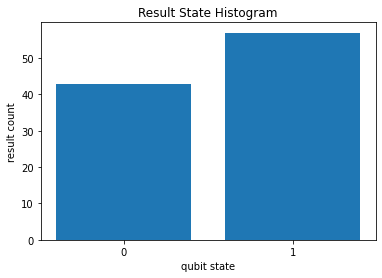

In [ ]:
runMainCircuit(1, 1)

Input Length:  2
Number of iterations:  1
Number of x such that f(x) = 1:  1
1 th one is:  00
Iteration no:  0
Circuit used to solve problem: 
0: ───H───X───@───X───H───X───@───X───H───M('result')───
              │               │           │
1: ───H───X───@───X───H───X───@───X───H───M─────────────
Results: 
result=0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, 0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Sampled results:
Counter({'00': 100})
Expected Success Rate:  100.0 %
Time taken to create circuit:  0.007311582565307617
Time taken for execution:  0.00989222526550293
Time taken by program:  0.017203807830810547


0.017203807830810547

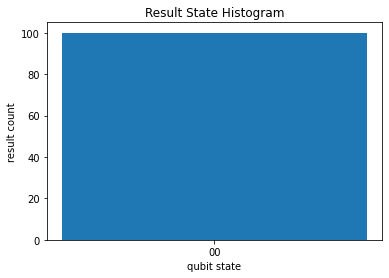

In [ ]:
runMainCircuit(2, 1)

Input Length:  2
Number of iterations:  1
Number of x such that f(x) = 1:  2
1 th one is:  00
2 th one is:  10
Iteration no:  0
Circuit used to solve problem: 
0: ───H───X───@───X───────@───H───X───────@───X───H───M('result')───
              │           │               │           │
1: ───H───X───@───X───X───@───X───H───X───@───X───H───M─────────────
Results: 
result=0010000001111100010111110100010011011001000010110010110000011101010001111101010111110000001001111010, 1111101010100110110010010000110110010100110011001110000111001001100101110010101111010001110110011010
Sampled results:
Counter({'01': 29, '10': 25, '11': 23, '00': 23})
Expected Success Rate:  49.999999999999964 %
Time taken to create circuit:  0.0037755966186523438
Time taken for execution:  0.009961366653442383
Time taken by program:  0.013736963272094727


0.013736963272094727

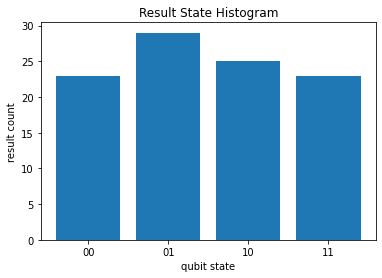

In [ ]:
runMainCircuit(2, 2)

Input Length:  2
Number of iterations:  1
Number of x such that f(x) = 1:  3
1 th one is:  00
2 th one is:  11
3 th one is:  01
Iteration no:  0
Circuit used to solve problem: 
0: ───H───X───@───X───@───X───@───X───H───X───@───X───H───M('result')───
              │       │       │               │           │
1: ───H───X───@───X───@───────@───H───X───────@───X───H───M─────────────
Results: 
result=1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111, 0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Sampled results:
Counter({'10': 100})
Expected Success Rate:  1.4997597826618575e-30 %
Time taken to create circuit:  0.0038537979125976562
Time taken for execution:  0.011311054229736328
Time taken by program:  0.015164852142333984


0.015164852142333984

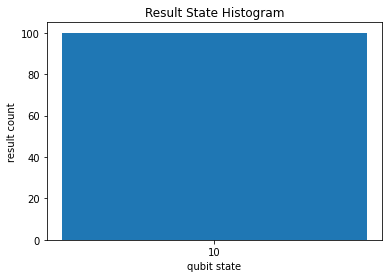

In [ ]:
runMainCircuit(2, 3)

Input Length:  3
Number of iterations:  2
Number of x such that f(x) = 1:  1
1 th one is:  110
Iteration no:  0
Iteration no:  1
Circuit used to solve problem: 
0: ───H───────@───H───X───────@───X───H───H───H───M('result')───
              │               │                   │
1: ───H───────@───H───X───────@───X───H───H───H───M─────────────
              │               │                   │
2: ───H───X───@───X───H───X───@───X───H───H───H───M─────────────
Results: 
result=1111101111111111111011111101111111110110111111111011011111111111111111111111111111111111111111111011, 1111111110111111111101011111111111110011111111101111111111111111111111111111111111100111111111111111, 0000000000000000010100000010000000000001000000110000000000000000000000000000000000010000000010000000
Sampled results:
Counter({'110': 82, '100': 5, '010': 4, '111': 3, '011': 3, '101': 2, '000': 1})
Expected Success Rate:  94.53124999999999 %
Time taken to create circuit:  0.011472940444946289
Time taken for execution

(0.011472940444946289, 0.011264562606811523)

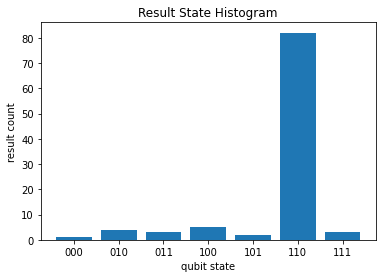

In [ ]:
runMainCircuit(3, 1)

Input Length:  3
Number of iterations:  1
Number of x such that f(x) = 1:  2
1 th one is:  101
2 th one is:  000
Iteration no:  0
Circuit used to solve problem: 
0: ───H───────@───X───────@───X───H───X───@───X───H───M('result')───
              │           │               │           │
1: ───H───X───@───X───X───@───X───H───X───@───X───H───M─────────────
              │           │               │           │
2: ───H───────@───X───────@───X───H───X───@───X───H───M─────────────
Results: 
result=0001001110010010000110010001010001101111011001010101111001001010111101010000001010110110000101010100, 0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, 0001001110010010000110010001010001101111011001010101111001001010111101010000001010110110000101010100
Sampled results:
Counter({'000': 55, '101': 45})
Expected Success Rate:  100.0 %
Time taken to create circuit:  0.0042629241943359375
Time taken for execution:  0.01921367645263672
Time taken by pr

0.023476600646972656

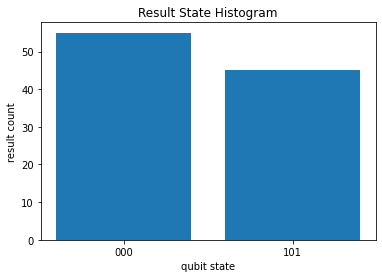

In [ ]:
runMainCircuit(3, 2)

Input Length:  3
Number of iterations:  1
Number of x such that f(x) = 1:  3
1 th one is:  011
2 th one is:  000
3 th one is:  100
Iteration no:  0
Circuit used to solve problem: 
0: ───H───X───@───X───X───@───X───────@───H───X───────@───X───H───M('result')───
              │           │           │               │           │
1: ───H───────@───X───────@───X───X───@───X───H───X───@───X───H───M─────────────
              │           │           │               │           │
2: ───H───────@───X───────@───X───X───@───X───H───X───@───X───H───M─────────────
Results: 
result=0001111001101100101000001000100110000001000100001001000000010100100100101001111100101001110001000000, 1010000110010011010001010001001000100000001011110110010101000111000000100000000110100000001000011101, 1010000110010011010001010001001010000000111011010110001101000101000100101000000110100000001000011101
Sampled results:
Counter({'000': 31, '100': 28, '011': 27, '010': 4, '111': 4, '101': 3, '001': 3})
Expected Success Ra

0.023618698120117188

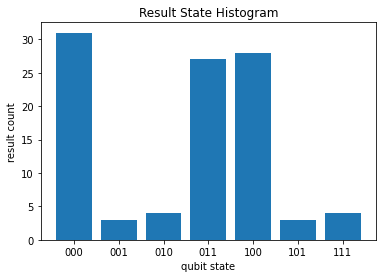

In [ ]:
runMainCircuit(3, 3)

Input Length:  3
Number of iterations:  1
Number of x such that f(x) = 1:  4
1 th one is:  011
2 th one is:  101
3 th one is:  001
4 th one is:  010
Iteration no:  0
Circuit used to solve problem: 
0: ───H───X───@───X───@───X───────@───X───X───@───X───H───X───@───X───H───M('result')───
              │       │           │           │               │           │
1: ───H───────@───X───@───X───X───@───X───────@───H───X───────@───X───H───M─────────────
              │       │           │           │               │           │
2: ───H───────@───────@───────────@───X───────@───X───H───X───@───X───H───M─────────────
Results: 
result=0110001111010000110100110011101010101010110100110001001110010011000010010101000011111000010101000101, 0101001001100110000111100000110010011011101000111101110001100011010110010001111000111010110000100111, 0111101111101100010110110101000011010011000111010100110111011001100000000100001111010011000111100101
Sampled results:
Counter({'000': 18, '101': 15, '011': 13, '1

0.0159146785736084

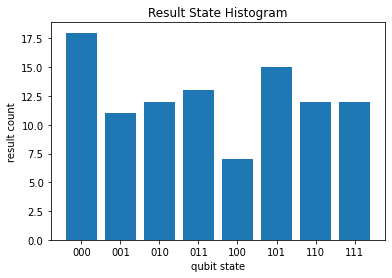

In [ ]:
runMainCircuit(3, 4)

Input Length:  3
Number of iterations:  1
Number of x such that f(x) = 1:  5
1 th one is:  010
2 th one is:  100
3 th one is:  001
4 th one is:  110
5 th one is:  101
Iteration no:  0
Circuit used to solve problem: 
0: ───H───X───@───X───────@───X───────@───X───@───────@───H───X───────@───X───H───M('result')───
              │           │           │       │       │               │           │
1: ───H───────@───X───────@───X───X───@───X───@───X───@───X───H───X───@───X───H───M─────────────
              │           │           │       │       │               │           │
2: ───H───X───@───X───X───@───X───────@───X───@───X───@───H───X───────@───X───H───M─────────────
Results: 
result=0011000000111111010100000110100001001100101100111000100100000110001110000001000010110010100110011001, 0111011110111111010000110111100101011100111011011111001101010111111110101011100011111011000011011111, 0011011110111011010000110011100101000100110110010111001101010110111110101011100010111011100111011011
Sam

0.03565073013305664

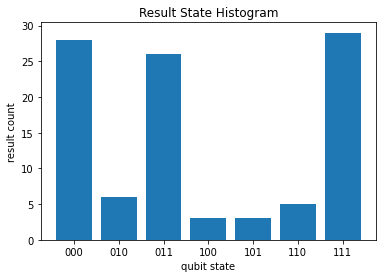

In [ ]:
runMainCircuit(3, 5)

Input Length:  3
Number of iterations:  1
Number of x such that f(x) = 1:  6
1 th one is:  011
2 th one is:  111
3 th one is:  110
4 th one is:  100
5 th one is:  001
6 th one is:  101
Iteration no:  0
Circuit used to solve problem: 
0: ───H───X───@───X───@───────@───────────@───X───────@───X───────@───H───X───────@───X───H───M('result')───
              │       │       │           │           │           │               │           │
1: ───H───────@───────@───────@───X───────@───X───X───@───X───X───@───X───H───X───@───X───H───M─────────────
              │       │       │           │           │           │               │           │
2: ───H───────@───────@───X───@───X───X───@───X───────@───────────@───H───X───────@───X───H───M─────────────
Results: 
result=0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, 1001000001000101001100110001001100111110010000111000100011100011111001011010100101100010000011010100, 00000000000000000000000000

0.03659868240356445

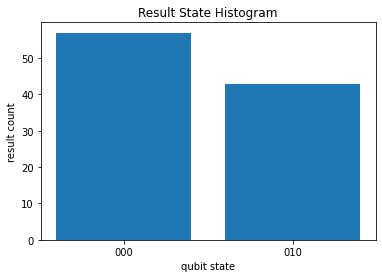

In [ ]:
runMainCircuit(3, 6)

Input Length:  3
Number of iterations:  1
Number of x such that f(x) = 1:  7
1 th one is:  001
2 th one is:  010
3 th one is:  101
4 th one is:  100
5 th one is:  110
6 th one is:  111
7 th one is:  000
Iteration no:  0
Circuit used to solve problem: 
0: ───H───X───@───X───X───@───X───@───────────@───────────@───────@───X───@───X───H───X───@───X───H───M('result')───
              │           │       │           │           │       │       │               │           │
1: ───H───X───@───X───────@───X───@───X───X───@───X───────@───────@───X───@───X───H───X───@───X───H───M─────────────
              │           │       │           │           │       │       │               │           │
2: ───H───────@───X───────@───X───@───X───────@───X───X───@───X───@───X───@───X───H───X───@───X───H───M─────────────
Results: 
result=0000000000000000000000000000000000000000000100010000000000011000000000000000000000010010000101011000, 1111111111111111110111111011111111111111111001101011110111100111101111

0.0413815975189209

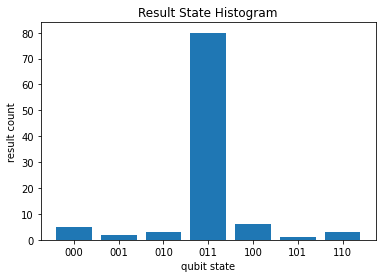

In [ ]:
runMainCircuit(3, 7)

Input Length:  4
Number of iterations:  3
Number of x such that f(x) = 1:  1
1 th one is:  0110
Iteration no:  0
Iteration no:  1
Iteration no:  2
Circuit used to solve problem: 
0: ───H───X───@───X───H───X───@───X───H───H───H───H───H───M('result')───
              │               │                           │
1: ───H───────@───H───X───────@───X───H───H───H───H───H───M─────────────
              │               │                           │
2: ───H───────@───H───X───────@───X───H───H───H───H───H───M─────────────
              │               │                           │
3: ───H───X───Z───X───H───X───Z───X───H───H───H───H───H───M─────────────
Results: 
result=0100010010000010110000000000001010101000011010100010101000000000110100100000110100000001000100110000, 1101111001111101011111111110100001010111100111111110110110110111010011011111101011001110110111111111, 1101111011111101101111011111100001011001101110111100111110101011010010001111101111001111110001011111, 00100100101000100100001000

0.027362823486328125

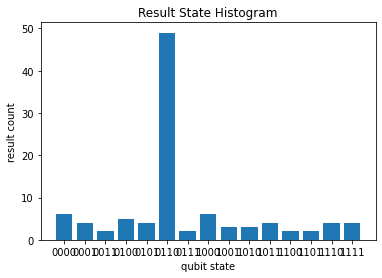

In [ ]:
runMainCircuit(4, 1)

Input Length:  5
Number of iterations:  4
Number of x such that f(x) = 1:  1
1 th one is:  11000
Iteration no:  0
Iteration no:  1
Iteration no:  2
Iteration no:  3
Circuit used to solve problem: 
0: ───H───────@───H───X───────@───X───H───H───H───H───H───H───H───M('result')───
              │               │                                   │
1: ───H───────@───H───X───────@───X───H───H───H───H───H───H───H───M─────────────
              │               │                                   │
2: ───H───X───@───X───H───X───@───X───H───H───H───H───H───H───H───M─────────────
              │               │                                   │
3: ───H───X───@───X───H───X───@───X───H───H───H───H───H───H───H───M─────────────
              │               │                                   │
4: ───H───X───Z───X───H───X───Z───X───H───H───H───H───H───H───H───M─────────────
Results: 
result=1110101111000001110111100111000011111000111110110001001100000110001101011101011000101111101101110101, 1101101

0.06923437118530273

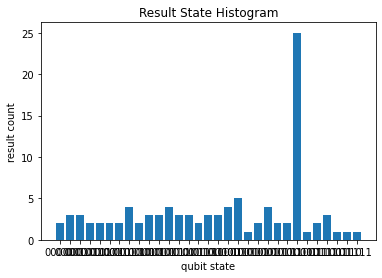

In [ ]:
runMainCircuit(5, 1)

Input Length:  6
Number of iterations:  6
Number of x such that f(x) = 1:  1
1 th one is:  100101
Iteration no:  0
Iteration no:  1
Iteration no:  2
Iteration no:  3
Iteration no:  4
Iteration no:  5
Circuit used to solve problem: 
0: ───H───────@───H───X───────@───X───H───H───H───H───H───H───H───H───H───H───H───M('result')───
              │               │                                                   │
1: ───H───X───@───X───H───X───@───X───H───H───H───H───H───H───H───H───H───H───H───M─────────────
              │               │                                                   │
2: ───H───X───@───X───H───X───@───X───H───H───H───H───H───H───H───H───H───H───H───M─────────────
              │               │                                                   │
3: ───H───────@───H───X───────@───X───H───H───H───H───H───H───H───H───H───H───H───M─────────────
              │               │                                                   │
4: ───H───X───@───X───H───X───@───X───H───H─

0.07345962524414062

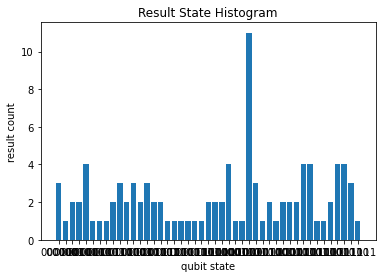

In [ ]:
runMainCircuit(6, 1)

Input Length:  7
Number of iterations:  8
Number of x such that f(x) = 1:  1
1 th one is:  0011000
Iteration no:  0
Iteration no:  1
Iteration no:  2
Iteration no:  3
Iteration no:  4
Iteration no:  5
Iteration no:  6
Iteration no:  7
Circuit used to solve problem: 
0: ───H───X───@───X───H───X───@───X───H───H───H───H───H───H───H───H───H───H───H───H───H───H───H───M('result')───
              │               │                                                                   │
1: ───H───X───@───X───H───X───@───X───H───H───H───H───H───H───H───H───H───H───H───H───H───H───H───M─────────────
              │               │                                                                   │
2: ───H───────@───H───X───────@───X───H───H───H───H───H───H───H───H───H───H───H───H───H───H───H───M─────────────
              │               │                                                                   │
3: ───H───────@───H───X───────@───X───H───H───H───H───H───H───H───H───H───H───H───H───H───H───

0.11237740516662598

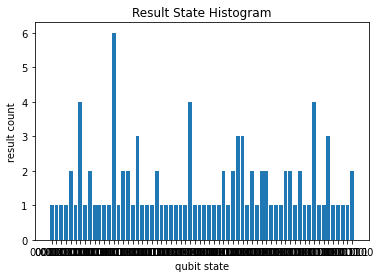

In [ ]:
runMainCircuit(7, 1)

Time for various Zf for n = 5 and a = 1

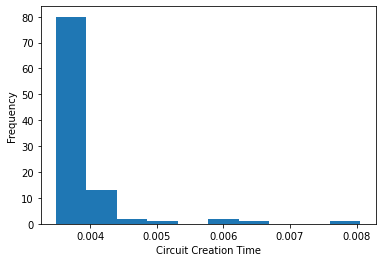

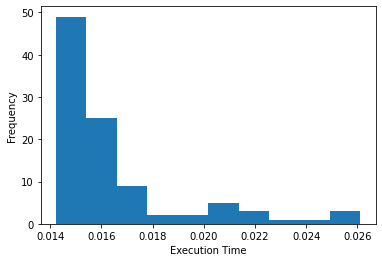

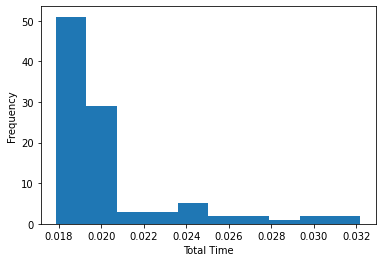

In [ ]:
circuitTimes = []
executionTimes = []
totalTimes = []
for i in range(100):
    (circuit, execution) = runMainCircuit(5, 1, False)
    circuitTimes.append(circuit)
    executionTimes.append(execution)
    totalTimes.append(circuit + execution)
plt.hist(circuitTimes)
plt.xlabel('Circuit Creation Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(executionTimes)
plt.xlabel('Execution Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(totalTimes)
plt.xlabel('Total Time')
plt.ylabel('Frequency')
plt.show() 

Effect of a on execution time

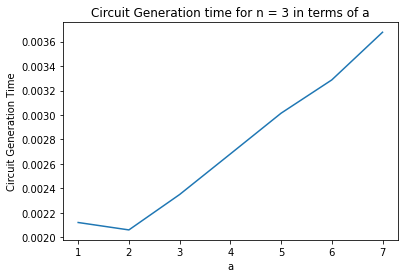

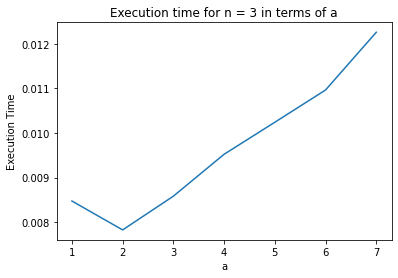

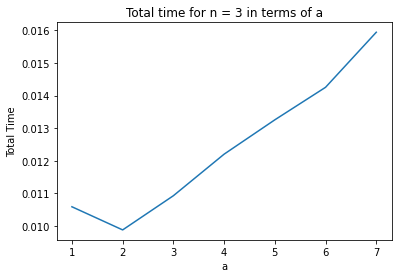

In [ ]:
circuitTimes = []
executionTimes = []
totalTimes = []
for a in range(1, 8):
    ct = 0
    et = 0
    tt = 0
    for i in range(100):
        (circuit, execution) = runMainCircuit(3, a, False)
        ct += circuit
        et += execution
        tt += circuit + execution
    circuitTimes.append(ct / 100)
    executionTimes.append(et / 100)
    totalTimes.append(tt / 100)

x_axis = [1, 2, 3, 4, 5, 6, 7]
plt.plot(x_axis, circuitTimes)
plt.title('Circuit Generation time for n = 3 in terms of a')
plt.ylabel('Circuit Generation Time')
plt.xlabel('a')
plt.show() 

plt.plot(x_axis, executionTimes)
plt.title('Execution time for n = 3 in terms of a')
plt.ylabel('Execution Time')
plt.xlabel('a')
plt.show() 

plt.plot(x_axis, totalTimes)
plt.title('Total time for n = 3 in terms of a')
plt.ylabel('Total Time')
plt.xlabel('a')
plt.show() 

Effect of n on execution time

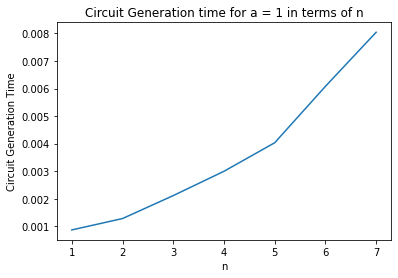

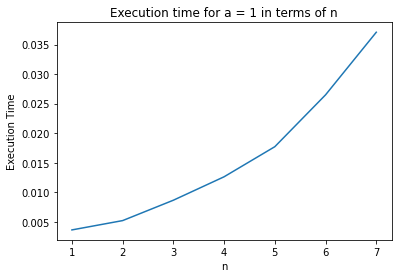

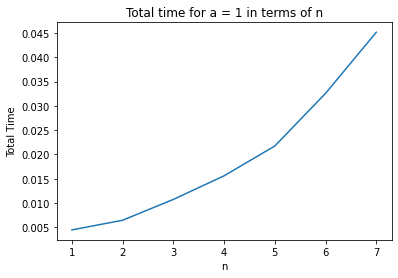

In [ ]:
circuitTimes = []
executionTimes = []
totalTimes = []
for n in range(1, 8):
    ct = 0
    et = 0
    tt = 0
    for i in range(100):
        (circuit, execution) = runMainCircuit(n, 1, False)
        ct += circuit
        et += execution
        tt += circuit + execution
    circuitTimes.append(ct / 100)
    executionTimes.append(et / 100)
    totalTimes.append(tt / 100)

x_axis = [1, 2, 3, 4, 5, 6, 7]
plt.plot(x_axis, circuitTimes)
plt.title('Circuit Generation time for a = 1 in terms of n')
plt.ylabel('Circuit Generation Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, executionTimes)
plt.title('Execution time for a = 1 in terms of n')
plt.ylabel('Execution Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, totalTimes)
plt.title('Total time for a = 1 in terms of n')
plt.ylabel('Total Time')
plt.xlabel('n')
plt.show() 

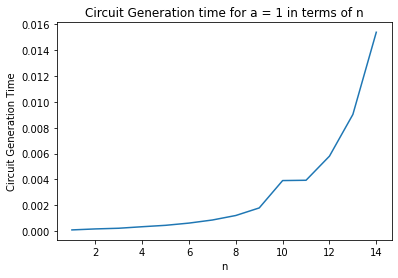

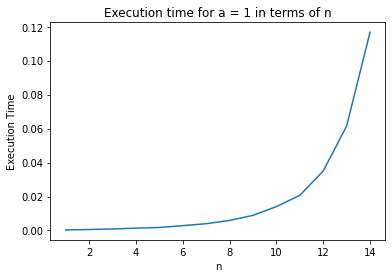

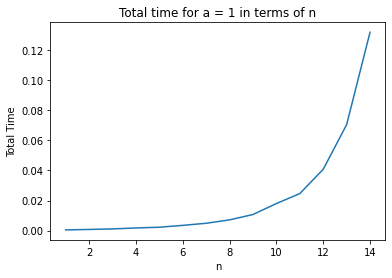

In [ ]:
circuitTimes = []
executionTimes = []
totalTimes = []
for n in range(1, 15):
    ct = 0
    et = 0
    tt = 0
    for i in range(10):
        (circuit, execution) = runMainCircuit(n, 1, False)
        ct += circuit
        et += execution
        tt += circuit + execution
    circuitTimes.append(ct / 100)
    executionTimes.append(et / 100)
    totalTimes.append(tt / 100)

x_axis = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
plt.plot(x_axis, circuitTimes)
plt.title('Circuit Generation time for a = 1 in terms of n')
plt.ylabel('Circuit Generation Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, executionTimes)
plt.title('Execution time for a = 1 in terms of n')
plt.ylabel('Execution Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, totalTimes)
plt.title('Total time for a = 1 in terms of n')
plt.ylabel('Total Time')
plt.xlabel('n')
plt.show() 